In [1]:
!pip install lightgbm

    100% |████████████████████████████████| 1.2MB 20.3MB/s ta 0:00:01


In [34]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve

In [3]:
IDIR = '../data/input/'

In [4]:
print('Загрузка данных о предыдущих заказах')
priors = pd.read_csv(IDIR + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('Загрузка обучающих данных')
train = pd.read_csv(IDIR + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('Загрузка данных о заказах')
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('Загрузка данных о продуктах')
products = pd.read_csv(IDIR + 'products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])

Загрузка данных о предыдущих заказах
Загрузка обучающих данных
Загрузка данных о заказах
Загрузка данных о продуктах


In [5]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
products.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


In [9]:
print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('train {}: {}'.format(train.shape, ', '.join(train.columns)))

priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered


Получим для каждого продукта долю повторных заказов

In [10]:

prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.int32)
prods['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)


In [11]:
prods.head()

,orders,reorders,reorder_rate
product_id,,,
1,1852,1136.0,0.613391
2,90,12.0,0.133333
3,277,203.0,0.732852
4,329,147.0,0.446809
5,15,9.0,0.600000


Объединим информацию о предыдущих покупках с информацией о заказах

In [12]:
orders.set_index('order_id', inplace=True, drop=False)
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)

In [13]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


Получим признаки для каждого пользователя: среднее число дней между покупками, число заказов и среднее число покупок между заказами

In [14]:
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)

In [15]:
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
print(users.shape)

(206209, 6)


Получим комбинации признаков для пользователей и для продуктов

In [16]:

priors['user_product'] = priors.product_id + priors.user_id * 100000

d = dict()
for row in tqdm_notebook(priors.itertuples()):
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)

Перегоним признаки в датафрейм

In [17]:
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d

In [18]:

userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print(len(userXproduct))

13293564


In [19]:
train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

Делаем локальную валидацию, нужно разбить на обучающую и тестовую выборки

In [20]:
train_orders = orders[orders.eval_set == 'train']

In [21]:
train_ids, val_ids = train_test_split(orders.query('eval_set == "train"')['user_id'].unique(), 
                                     test_size = 0.3, 
                                     random_state = 1)

Функция для подсчета признаков

In [22]:
def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in tqdm_notebook(selected_orders.itertuples()):
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    #df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                              df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

Получим признаки для обучающей выборки и обучим модель

In [23]:
df_train, labels = features(orders[orders.user_id.isin(train_ids)], labels_given=True)

f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] 


# Преобразование датафрейма в формат LGBM
d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id'])  # , 'order_hour_of_day', 'dow'
del df_train

build candidate list


order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
order row 110000
order row 120000
order row 130000
order row 140000
order row 150000
order row 160000
order row 170000
order row 180000
order row 190000
order row 200000
order row 210000
order row 220000
order row 230000
order row 240000
order row 250000
order row 260000
order row 270000
order row 280000
order row 290000
order row 300000
order row 310000
order row 320000
order row 330000
order row 340000
order row 350000
order row 360000
order row 370000
order row 380000
order row 390000
order row 400000
order row 410000
order row 420000
order row 430000
order row 440000
order row 450000
order row 460000
order row 470000
order row 480000
order row 490000
order row 500000
order row 510000
order row 520000
order row 530000
order row 540000
order row 550000
order row 560000
order row 570000
order row 580000
order row 590000
order 

In [25]:


params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

# Собственно обучение
bst = lgb.train(params, d_train, ROUNDS)
#del d_train

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [ ]:
bst.

In [24]:
import pickle
with open('d_train.pkl', 'wb') as f:
    pickle.dump(d_train, f, protocol=4)

In [49]:
del train

Построение валидационной выборки

In [ ]:
df_test, _ = features(orders[orders.user_id.isin(val_ids)], labels_given=True)

build candidate list


order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
order row 110000
order row 120000
order row 130000
order row 140000
order row 150000
order row 160000
order row 170000
order row 180000
order row 190000
order row 200000
order row 210000
order row 220000
order row 230000
order row 240000
order row 250000
order row 260000
order row 270000
order row 280000
order row 290000
order row 300000
order row 310000
order row 320000
order row 330000
order row 340000
order row 350000
order row 360000
order row 370000
order row 380000
order row 390000
order row 400000
order row 410000
order row 420000
order row 430000
order row 440000
order row 450000
order row 460000
order row 470000
order row 480000
order row 490000
order row 500000


In [27]:
import pickle
with open('df_test.pkl', 'wb') as f:
    pickle.dump(df_test, f, protocol=4)

In [28]:
preds = bst.predict(df_test[f_to_use])

df_test['pred'] = preds

light GBM predict


In [ ]:
precision, recall, thresholds = precision_recall_curve(df_test)

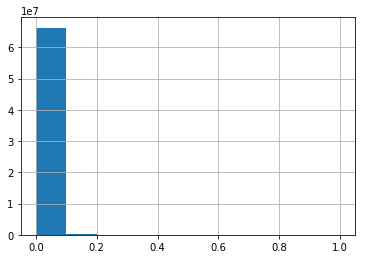

In [33]:
df_test.pred.hist()

In [30]:
df_test.columns

Index(['order_id', 'product_id', 'user_total_orders', 'user_total_items',
       'total_distinct_items', 'user_average_days_between_orders',
       'user_average_basket', 'order_hour_of_day', 'days_since_prior_order',
       'days_since_ratio', 'aisle_id', 'department_id', 'product_orders',
       'product_reorders', 'product_reorder_rate', 'UP_orders',
       'UP_orders_ratio', 'UP_average_pos_in_cart', 'UP_reorder_rate',
       'UP_orders_since_last', 'UP_delta_hour_vs_last', 'pred'],
      dtype='object')

In [29]:
df_test.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,pred
0,2168274,45066,15,195,102,16.285715,13.0,11,NaN,NaN,...,79769,57818.0,0.724818,3,0.200000,11.000000,0.200000,8,1,0.000010
1,2168274,2573,15,195,102,16.285715,13.0,11,NaN,NaN,...,1212,480.0,0.396040,2,0.133333,10.500000,0.133333,1,1,0.000014
2,2168274,18961,15,195,102,16.285715,13.0,11,NaN,NaN,...,130,30.0,0.230769,1,0.066667,8.000000,0.066667,6,2,0.000009
3,2168274,23,15,195,102,16.285715,13.0,11,NaN,NaN,...,1068,479.0,0.448502,1,0.066667,12.000000,0.066667,7,4,0.000009
4,2168274,32792,15,195,102,16.285715,13.0,11,NaN,NaN,...,1370,791.0,0.577372,9,0.600000,1.222222,0.600000,3,2,0.000015


In [ ]:
TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

